In [14]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTENC
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, chi2
import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [15]:
pd.set_option("max_columns",50)
data=pd.read_csv('C:/Users/Azerty/Desktop/Customer churn/data.csv')
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Feature engineering

## Categorical Data 

In [17]:
for column in data.select_dtypes(include='object'):
    print("Column: {} - Nbr of unique values: {} - unique values {} ".format(column, len(data[column].unique()),data[column].unique()))

Column: customerID - Nbr of unique values: 7043 - unique values ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] 
Column: gender - Nbr of unique values: 2 - unique values ['Female' 'Male'] 
Column: Partner - Nbr of unique values: 2 - unique values ['Yes' 'No'] 
Column: Dependents - Nbr of unique values: 2 - unique values ['No' 'Yes'] 
Column: PhoneService - Nbr of unique values: 2 - unique values ['No' 'Yes'] 
Column: MultipleLines - Nbr of unique values: 3 - unique values ['No phone service' 'No' 'Yes'] 
Column: InternetService - Nbr of unique values: 3 - unique values ['DSL' 'Fiber optic' 'No'] 
Column: OnlineSecurity - Nbr of unique values: 3 - unique values ['No' 'Yes' 'No internet service'] 
Column: OnlineBackup - Nbr of unique values: 3 - unique values ['Yes' 'No' 'No internet service'] 
Column: DeviceProtection - Nbr of unique values: 3 - unique values ['No' 'Yes' 'No internet service'] 
Column: TechSupport - Nbr of unique values: 3 - unique v

In [18]:
data.drop(columns=['customerID'],inplace=True)
data['TotalCharges']=pd.to_numeric(data['TotalCharges'],downcast='float',errors='coerce')

In [19]:
print("Nbr of Nan values in TotalCharges column: {} ".format(data[data['TotalCharges'].isna()==True].shape[1]))

Nbr of Nan values in TotalCharges column: 20 


In [20]:
data.dropna(subset=['TotalCharges'],inplace=True)

In [21]:
# train test split
X=data[data.columns.difference(['Churn'])]
y=data['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((5625, 19), (1407, 19))

In [22]:
catg = X_train.select_dtypes(include='object').columns
l_encoder_X={}
for feature in catg:
    l_encoder=preprocessing.LabelEncoder()
    X_train[feature] = l_encoder.fit_transform(X_train[feature])
    l_encoder_X[feature]=l_encoder
    
l_encoder_y=preprocessing.LabelEncoder()
y_train = pd.Series(l_encoder_y.fit_transform(y_train),index=X_train.index)


In [23]:
X_train.head()

Contract  Dependents  DeviceProtection  InternetService  MonthlyCharges  \
2964         1           0                 0                0           58.35   
5113         2           1                 2                1          113.65   
5363         2           1                 1                2           25.35   
5074         1           1                 1                2           19.45   
156          0           0                 0                1           84.15   

      MultipleLines  OnlineBackup  OnlineSecurity  PaperlessBilling  Partner  \
2964              2             0               2                 1        1   
5113              2             2               2                 0        1   
5363              2             1               1                 0        1   
5074              0             1               1                 0        0   
156               2             0               0                 1        0   

      PaymentMethod  PhoneService  SeniorCitizen  StreamingMovies  \
2964              2             1              0                0   
5113              1             1              0                2   
5363              3             1              0                1   
5074              1             1              0                1   
156               0             1              0                0   

      StreamingTV  TechSupport  TotalCharges  gender  tenure  
2964            0            2   1346.900024       1      24  
5113            2            2   8166.799805       0      71  
5363            1            1   1715.150024       1      70  
5074            1            1    921.299988       0      49  
156             2            0   1821.949951       0      22

## Dealing with class imbalance

<AxesSubplot:>

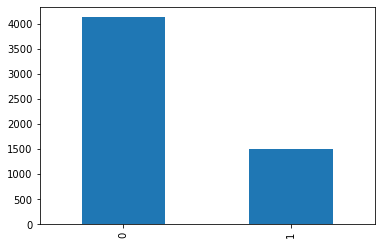

In [24]:
# Churn countplot
y_train.value_counts().plot(kind='bar')

**Observation :** problem of unbalanced data

In [25]:
print("Number of elements in class 1 : {}% , Number of elements in class 0 : {}%".format(round(y_train[y_train==0].count()*100/y_train.shape[0]),round(y_train[y_train==1].count()*100/y_train.shape[0])))

Number of elements in class 1 : 73% , Number of elements in class 0 : 27%


In [26]:
# create synthetic data using SMOTENC
categorical_features=[i for i in range(0,19) if i not in [4,16]]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=0)
X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)
print("Number of elements in class 1 : {}% , Number of elements in class 0 : {}%".format(round(y_train_res[y_train_res==0].count()*100/y_train_res.shape[0]),round(y_train_res[y_train_res==1].count()*100/y_train_res.shape[0])))

Number of elements in class 1 : 50% , Number of elements in class 0 : 50%


# Feature Selection

### Variance threshold

In [28]:
# variance threshold : check if there is  constant columns by using VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(X_train_res)
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

### Pairwise correlation

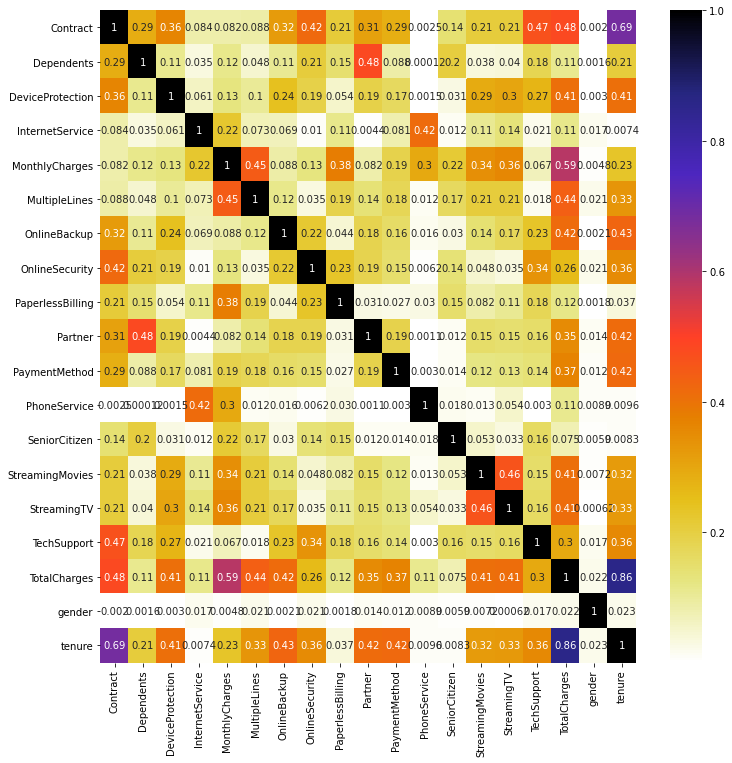

In [29]:
#Using Pearson Correlation
plt.figure(figsize=(12,12))
cor = X_train_res.corr()
sns.heatmap(abs(cor), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

I have choosed as correlation tolerance 0.7 value. thus, i will drop either the column TotalCharges or tenure. For that i will discard variable with weaker correlation with the target (Churn)

In [30]:
abs(X_train_res.corrwith(y_train_res,method="pearson",axis = 0)).sort_values(ascending=False)

Contract            0.509550
tenure              0.430857
OnlineSecurity      0.390436
TechSupport         0.381078
PaperlessBilling    0.284586
Dependents          0.258693
OnlineBackup        0.256792
TotalCharges        0.244287
MonthlyCharges      0.227991
DeviceProtection    0.222534
Partner             0.213569
PaymentMethod       0.199492
SeniorCitizen       0.139373
MultipleLines       0.048695
StreamingTV         0.042306
InternetService     0.038542
StreamingMovies     0.031382
PhoneService        0.021542
gender              0.013821
dtype: float64

TotalCharges has weaker coorelation with target than Tenure

In [31]:
X_train_res.drop(columns=['TotalCharges'],inplace=True)

**Other observations :** 

MonthlyCharges and TotalCharges are also correlated (moderate correlation ≈ 0.6) which it is makes sense : TotalCharges = Monthly Charges * tenure.

There is also a moderate positive relationship between Contract and Tenure

The fact there was two variables highly correlated (> 0.8) is a sign indicating that a severe **multicollinearity** may be present. 

### Multicollinearity 

In [32]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Features"] = X_train_res.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_res.values, i)
                   for i in range(len(X_train_res.columns))]

vif_data.sort_values(ascending=False,by='VIF')

Features        VIF
4     MonthlyCharges  17.040936
11      PhoneService  16.338968
17            tenure   7.010741
3    InternetService   4.609323
8   PaperlessBilling   3.633817
10     PaymentMethod   3.615176
0           Contract   3.576443
14       StreamingTV   3.247887
13   StreamingMovies   3.232414
5      MultipleLines   2.904518
9            Partner   2.653895
2   DeviceProtection   2.359146
6       OnlineBackup   2.228968
15       TechSupport   2.139877
7     OnlineSecurity   2.025274
16            gender   1.962401
1         Dependents   1.884475
12     SeniorCitizen   1.384663

Even after deleting TotalCharges, there still a sign of multicollinearity (VIF >10). However, for this case, it better to ignore the issue and live with what we have given the importance of the features involved. 

### Statistical Test (For feature Selection)

**Note:** Given the very small number of quantitative data (Tenure and Monthly Charge), i will apply the feature selection  on only categorical features

In [33]:
# chi-test : calculate p value and compare to the significance level (0.05)
columns_cat= [feature for feature in X_train_res.columns if feature not in ['tenure','MonthlyCharges']]
f_p_values=chi2(X_train_res[columns_cat],y_train_res)
p_values=pd.DataFrame(f_p_values[1],index=columns_cat,columns=['p_value'])
p_values['compare_to_alpha(0.05)']=p_values.apply(lambda y: True if y['p_value']<0.05 else False,axis=1)
p_values

p_value  compare_to_alpha(0.05)
Contract           0.000000e+00                    True
Dependents         1.424148e-93                    True
DeviceProtection   2.714167e-90                    True
InternetService    1.141419e-02                    True
MultipleLines      1.842063e-05                    True
OnlineBackup      9.333039e-121                    True
OnlineSecurity    2.340133e-306                    True
PaperlessBilling   1.039193e-49                    True
Partner            2.799719e-49                    True
PaymentMethod      4.268000e-42                    True
PhoneService       5.474079e-01                   False
SeniorCitizen      1.739680e-30                    True
StreamingMovies    8.961354e-03                    True
StreamingTV        3.774790e-04                    True
TechSupport       2.057261e-290                    True
gender             3.798509e-01                   False

**Conclusion :** PhoneService and gender are not a significants features.

In [34]:
# Select the 10 best categorical features that having the highest score amang all the categorical varaiables
selector = SelectKBest(chi2, k=10)
X_catg=X_train_res[columns_cat]
selector.fit(X_catg,y_train_res)
# Get columns to keep from the selector
cols = selector.get_support(indices=True)
X_train_res=pd.concat([X_catg.iloc[:,cols], X_train_res[['tenure','MonthlyCharges']]], join = 'outer', axis = 1)
X_train_res

Contract  Dependents  DeviceProtection  OnlineBackup  OnlineSecurity  \
0            1           0                 0             0               2   
1            2           1                 2             2               2   
2            2           1                 1             1               1   
3            1           1                 1             1               1   
4            0           0                 0             0               0   
...        ...         ...               ...           ...             ...   
8245         0           0                 2             0               0   
8246         0           0                 0             0               0   
8247         0           0                 2             0               0   
8248         0           0                 2             0               0   
8249         1           0                 0             2               0   

      PaperlessBilling  Partner  PaymentMethod  SeniorCitizen  TechSupport  \
0                    1        1              2              0            2   
1                    0        1              1              0            2   
2                    0        1              3              0            1   
3                    0        0              1              0            1   
4                    1        0              0              0            0   
...                ...      ...            ...            ...          ...   
8245                 1        0              2              0            0   
8246                 1        1              2              0            0   
8247                 1        0              2              0            0   
8248                 1        0              2              1            0   
8249                 1        0              2              0            2   

      tenure  MonthlyCharges  
0         24       58.350000  
1         71      113.650000  
2         70       25.350000  
3         49       19.450000  
4         22       84.150000  
...      ...             ...  
8245       4       73.073982  
8246      33       84.582119  
8247       5       94.773114  
8248       8       93.422205  
8249      68      103.727497  

[8250 rows x 12 columns]

# Model Selection

In [35]:
def algorithm_pipeline(X_train_data, y_train_data, 
                       model, param_grid, cv=StratifiedKFold(5), scoring='f1'):# because there was the problem of class imbalance, i have choosed to use f1-score as metric to evaluate the performance of classifiers
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=3
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    return fitted_model

## Boosting (Ensemble Modeling)

### XGBoost

In [36]:
param_grid1={
    'n_estimators' : [1000,1500,2000],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'max_depth' : [10,15,20],
    'learning_rate': [0.001,0.01]
}

In [37]:
model1 = xgboost.XGBClassifier(random_state=0,objective='binary:logistic',booster='gbtree',eval_metric='logloss',use_label_encoder=False)

model1= algorithm_pipeline(X_train_res, y_train_res,model1, param_grid1)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [38]:
# best score
model1.best_score_

0.8312373615066742

In [39]:
# best hyperparameters
model1.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.001,
 'max_depth': 15,
 'n_estimators': 2000,
 'subsample': 0.9}

In [40]:
# select the best model
xgbmodel=model1.best_estimator_

### LightGBM 

LightGBM is a another gradient boosting framework that uses tree based learning algorithms. It is designed to be more distributed and efficient than Xgboot:

* Faster training speed and higher efficiency.

* Lower memory usage.

* Better accuracy.

* Capable of handling large-scale data.

In [41]:
model2 = lgb.LGBMClassifier(random_state=0,boosting_type='gbdt',objective='binary')
param_grid2 = {
    'n_estimators': [1000,1500,2000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 150],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20],
    'learning_rate': [0.001]
}

model2 = algorithm_pipeline(X_train_res, y_train_res, model2, param_grid2)
print('best score:{}'.format(model2.best_score_))
print('best hyperparameters:{}'.format(model2.best_params_))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
best score:0.8232904800631495
best hyperparameters:{'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 20, 'min_split_gain': 0.3, 'n_estimators': 1000, 'num_leaves': 150, 'subsample': 0.9, 'subsample_freq': 20}


In [42]:
# select the best model
lgbmodel=model2.best_estimator_

## Bagging (Ensemble Modeling)

### Random Forest

In [44]:
model3 = RandomForestClassifier()
param_grid3 = {
    'n_estimators': [700, 1000,1500,2000],
    'max_depth': [15,20,25],
    'max_leaf_nodes': [50, 100, 200]
}

model3 = algorithm_pipeline(X_train_res, y_train_res, model3, param_grid3)

print('best score:{}'.format(model3.best_score_))
print('best hyperparameters:{}'.format(model3.best_params_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
best score:0.8234061432448291
best hyperparameters:{'max_depth': 15, 'max_leaf_nodes': 200, 'n_estimators': 700}


In [45]:
# select the best model
rfmodel=model3.best_estimator_

**Observation :** Relatively all models had a f1-score around 82 which can be considered a good score. However, to truly evaluate the generalization performance of thoses classifiers, we need to measure their performance against a data that doesn't contain synthetic data created using SMOTENC 

# Testing

In [47]:
# label encoding y_test/X_test
for feature in catg:
    X_test[feature] = l_encoder_X[feature].transform(X_test[feature])
    
X_test=X_test[X_train_res.columns]
y_test = pd.Series(l_encoder_y.transform(y_test),index=X_test.index)

In [48]:
preds1 = xgbmodel.predict(X_test)
f1_score(y_test, preds1)

0.6062111801242236

In [49]:
preds2 = lgbmodel.predict(X_test)
f1_score(y_test, preds2)

0.6120996441281139

In [50]:
preds3 = rfmodel.predict(X_test)
f1_score(y_test, preds3)

0.6067961165048543

**Conclusion :** the classifiers perform poorly on test data (f1-scores have dropped by 20%). the class imbalance as well as the train data size lead to poor results. I have tried to solve the problem by using cross-validation (use all the train data, see if there is any overfitting ...) and SMOTE ( oversampling : created new data for the minority class) but that doesn't improve as i want the performance of models. I also tried weight balancing (The idea is to weigh the loss computed for different samples differently based on whether they belong to the majority or the minority classes) but the result still the same.

This project is an example of how data imbalance can affect the performance of models and how it is critical to assure that we have balanced data or at least enough data to cope with this problem. 